In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gc

%load_ext autoreload
%autoreload 2

from dataloader import get_data, get_data_3d
from sklearn.model_selection import train_test_split


In [176]:
#labels = ['x', 'y', 'z', 'time', , 'dir_x', 'dir_y', 'dir_z', 'energy']
labels = ['azimuth','zenith']
reco_labels = labels #[:-1]

Xs = []
ys = []
rs = []


for i in range(10):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        X, y, r = get_data_3d(
            fname,
            labels = labels,
            reco_labels = reco_labels,
            N_events=None,
            min_pulses=10,
            )
        Xs.append(X)
        ys.append(y)
        rs.append(r)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

X_data = np.concatenate(Xs)
X_params = np.concatenate(ys)
r = np.concatenate(rs)
    
r = np.nan_to_num(r)
    
N_events, N_channels, N_features = X_data.shape
_, N_labels = X_params.shape



Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


100%|██████████| 9082/9082 [00:24<00:00, 369.26it/s]


In [177]:
X_data_train, X_data_test, X_params_train, X_params_test, r_train, r_test = train_test_split(X_data, X_params, r, test_size=0.1, random_state=42)

In [178]:
class trafo(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(trafo, self).__init__()
        self.num_outputs = num_outputs

    def call(self, input):
        
        dir_x = tf.math.sin(input[:, 1]) * tf.math.cos(input[:, 0])
        dir_y = tf.math.sin(input[:, 1]) * tf.math.sin(input[:, 0])
        dir_z = tf.math.cos(input[:, 1])

        out =  tf.concat([dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis]], axis=1)
        
        return out

In [185]:

activation='relu'


# Data network

inputs_data = tf.keras.Input(shape=(N_channels, N_features), )

h = tf.keras.layers.Reshape((86, 60 * N_features))(inputs_data)
h = tf.keras.layers.Dropout(0.01)(h)
ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h)
dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h)

n1 = 64
h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n1, activation=activation, input_shape=(60 * N_features,)), input_shape=(78, 60 * N_features))(ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n1, activation=activation, input_shape=(60 * N_features,)), input_shape=(8, 60 * N_features))(dc)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(n1,)), input_shape=(78,n1))(h_ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(n1,)), input_shape=(8,n1))(h_dc)

h = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

h = tf.keras.layers.Flatten(input_shape=(86, 16))(h)

h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)
h = tf.keras.layers.Dense(32, activation=activation)(h)
outputs_data = tf.keras.layers.Dense(32, activation=activation)(h)

model_data = tf.keras.Model(inputs=inputs_data, outputs=outputs_data)




# # Data network CNN


# inputs_data = tf.keras.Input(shape=(N_channels, N_features), )

# h = tf.keras.layers.Reshape((86, 60, N_features, 1))(inputs_data)

# h = tf.keras.layers.Dropout(0.01)(h)
# ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h)
# dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h)

# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (5, N_features), activation=activation, input_shape=(60, N_features,)), input_shape=(78, 60, N_features))(ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (5, N_features), activation=activation, input_shape=(60, N_features,)), input_shape=(8, 60, N_features))(dc)

# h_ic = tf.keras.layers.Reshape((78, 56, 64))(h_ic)
# h_dc = tf.keras.layers.Reshape((8, 56, 64))(h_dc)

# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling1D((2,), input_shape=(56,)), input_shape=(78, 56))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling1D((2,), input_shape=(56,)), input_shape=(8, 56))(h_dc)


# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, (2, ), activation=activation, input_shape=(28,)), input_shape=(78, 28))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, (2, ), activation=activation, input_shape=(28,)), input_shape=(8, 28))(h_dc)


# #h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (5,3), activation=activation, input_shape=(28, 5,)), input_shape=(78, 28, 5))(h_ic)
# #h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (5,3), activation=activation, input_shape=(28, 5,)), input_shape=(8, 28, 5))(h_dc)


# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten(input_shape=(28,)), input_shape=(78, 28))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten(input_shape=(28,)), input_shape=(8, 28))(h_dc)

# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(896,)), input_shape=(78,896))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(896,)), input_shape=(8,896))(h_dc)


# h = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

# h = tf.keras.layers.Flatten(input_shape=(86, 16))(h)

# #h = tf.keras.layers.AveragePooling2D((1,2))(h)

# #h = tf.keras.layers.Conv2D(32, (1, 5), activation=activation)(h)

# #h = tf.keras.layers.AveragePooling2D((1,2))(h)

# #h = tf.keras.layers.Conv2D(32, (1, 5), activation=activation)(h)

# #h = tf.keras.layers.AveragePooling2D((1,2))(h)

# #h = tf.keras.layers.Flatten()(h)

# h = tf.keras.layers.Dense(32, activation=activation)(h)
# h = tf.keras.layers.Dropout(0.01)(h)
# h = tf.keras.layers.Dense(32, activation=activation)(h)
# outputs_data = tf.keras.layers.Dense(32, activation=activation)(h)

# model_data = tf.keras.Model(inputs=inputs_data, outputs=outputs_data)







# Parameters network

p_activation = 'relu'

inputs_params = tf.keras.Input(shape=(N_labels,))

y = trafo(3)(inputs_params)

y = tf.keras.layers.Dense(32, activation=p_activation)(y)
#y = tf.keras.layers.Dense(128, activation=p_activation)(y)
#y = tf.keras.layers.Dense(128, activation=p_activation)(y)
#y = tf.keras.layers.Dense(32, activation=p_activation)(y)
#y = tf.keras.layers.Dropout(0.01)(y)
y = tf.keras.layers.Dense(64, activation=p_activation)(y)
y = tf.keras.layers.Dense(128, activation=p_activation)(y)
y = tf.keras.layers.Dense(64, activation=p_activation)(y)
outputs_params = tf.keras.layers.Dense(32, activation=p_activation)(y)

model_params = tf.keras.Model(inputs=inputs_params, outputs=outputs_params)


combined = tf.keras.layers.Concatenate()([model_data.output, model_params.output])


z = tf.keras.layers.Dense(128, activation="relu")(combined)
#z = tf.keras.layers.Dense(32, activation="relu")(z)
z = tf.keras.layers.Dropout(0.01)(z)
z = tf.keras.layers.Dense(64, activation="relu")(z)
z = tf.keras.layers.Dense(32, activation="relu")(z)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(z)


# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[model_data.input, model_params.input], outputs=outputs)

model.summary()

loss_history = []
val_loss_history = []

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 5160, 7)]    0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 86, 420)      0           input_9[0][0]                    
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 86, 420)      0           reshape_4[0][0]                  
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 78, 420)      0           dropout_16[0][0]                 
___________________________________________________________________________________________

In [186]:
#optimizer = tf.keras.optimizers.SGD(0.01)
#optimizer = tf.keras.optimizers.RMSprop(0.001, )
#optimizer = tf.keras.optimizers.Nadam(0.001)
optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [181]:
del inputs_train
del outputs_train
del inputs_test
del outputs_test
gc.collect()

2624

In [182]:
inputs_train = [np.vstack([X_data_train, X_data_train]),  np.vstack([X_params_train, np.random.permutation(X_params_train)])]
outputs_train = np.concatenate([np.ones(X_data_train.shape[0]), np.zeros(X_data_train.shape[0])])
                
inputs_test = [np.vstack([X_data_test, X_data_test]),  np.vstack([X_params_test, np.random.permutation(X_params_test)])]
outputs_test = np.concatenate([np.ones(X_data_test.shape[0]), np.zeros(X_data_test.shape[0])])

In [221]:
for i in range(3):
    # re-shuffle
    inputs_train[1] = np.vstack([X_params_train, np.random.permutation(X_params_train)])
    inputs_test[1] = np.vstack([X_params_test, np.random.permutation(X_params_test)])
    
    # sample from flat
#     rand_train_params = np.random.uniform(size=X_params_train.size).reshape(X_params_train.shape)
#     rand_test_params = np.random.uniform(size=X_params_test.size).reshape(X_params_test.shape)
    
#     # zen / az
#     #rand_train_params[:,0] = np.arccos((rand_train_params[:,0] * 2) - 1)
#     #rand_train_params[:,1] *= 2 * np.pi
#     #rand_test_params[:,0] = np.arccos((rand_test_params[:,0]) * 2 - 1)
#     #rand_test_params[:,1] *= 2 * np.pi
    
#     # scale
#     bounds = np.quantile(X_params, [0., 1.], axis=0)
#     delta = np.diff(bounds, axis=0)
#     rand_train_params *= delta
#     rand_test_params *= delta
#     rand_train_params += bounds[0]
#     rand_test_params += bounds[0]

#     inputs_train[1] = np.vstack([X_params_train, rand_train_params])
#     inputs_test[1] = np.vstack([X_params_test, rand_test_params])
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    model.fit(inputs_train, outputs_train, batch_size=512, epochs=1, validation_data=(inputs_test, outputs_test))

    loss_history.append(model.history.history['loss'])
    val_loss_history.append(model.history.history['val_loss'])
    

Epoch 7
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 8s 56us/sample - loss: 0.6484 - val_loss: 0.6460
Epoch 8
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 9s 61us/sample - loss: 0.6404 - val_loss: 0.6406
Epoch 9
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 8s 55us/sample - loss: 0.6363 - val_loss: 0.6371


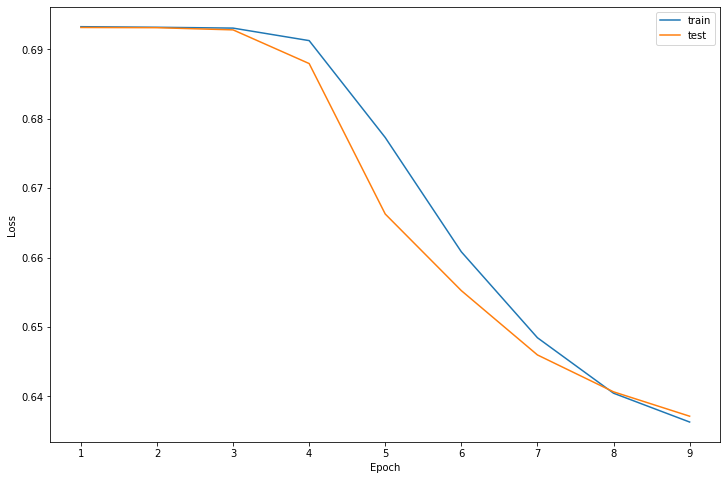

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
#ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [216]:
event_idx = 3311

true_x = X_params_test[event_idx, 0]
true_y = X_params_test[event_idx, 1]

In [217]:
xs = np.linspace(0, 2*np.pi, 100)
#xs = np.linspace(true_x-100, true_x+100, 100)
ys = np.repeat(true_y, xs.shape[0])

params = np.stack([xs, ys]).T
data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

likelihood = model.predict([data, params], batch_size=512)


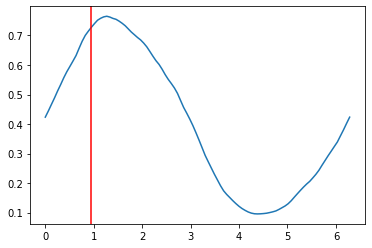

In [218]:
plt.plot(xs, likelihood)
plt.axvline(true_x, c='r')

In [219]:
%%time
N = 101
d = 100
#xs = np.linspace(true_x-d, true_x+d, N)
#ys = np.linspace(true_y-d, true_y+d, N)

xs = np.linspace(0, 2*np.pi, N)
ys = np.linspace(0, np.pi, N)


xx, yy = np.meshgrid(xs,ys)

xx = xx.flatten()
yy = yy.flatten()

params = np.stack([xx, yy]).T
data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

likelihood = model.predict([data, params], batch_size=512)

z = likelihood.reshape((xs.shape[0], ys.shape[0]))

CPU times: user 6.83 s, sys: 19.9 s, total: 26.7 s
Wall time: 3.95 s


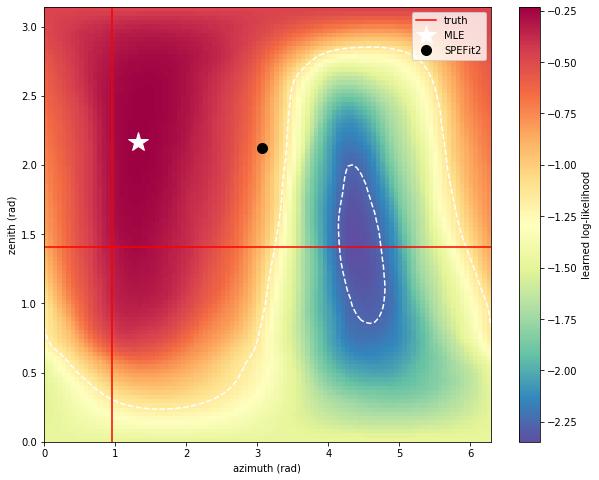

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

im = ax.imshow(np.log(z), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower', cmap='Spectral_r', aspect='auto')
ax.axvline(true_x, c='r')
ax.axhline(true_y, c='r', label='truth')

plt.colorbar(im, ax=ax, label='learned log-likelihood', )

plt.contour(xs, ys, np.log(z), [-9.21/2, -5.99/2, -4.51/2, -2.3/2], colors='w')

plt.plot(xx[np.argmax(z)],  yy[np.argmax(z)], marker='*', color='w', lw=0, ms=20, label='MLE')

plt.plot(r_test[event_idx][0],  r_test[event_idx][1], marker='o', color='k', lw=0, ms=10, label='SPEFit2')


#ax.set_xlabel('x position (m)')
#ax.set_ylabel('y position (m)')

#ax.set_xlabel('x position (m)')
#ax.set_ylabel('z position (m)')

ax.set_xlabel('azimuth (rad)')
ax.set_ylabel('zenith (rad)')

plt.legend()

#plt.savefig('x-y_vertex_evnt%i.png'%event_idx, dpi=150)